In [1]:
import mne
import time
import scipy.signal
import numpy                as     np 
import matplotlib.animation as     animation
import matplotlib.pyplot    as     plt
from   joblib               import Parallel, delayed

In [2]:
def smooth_spectra(spectra, win_time, win_freq, fft=False):
    kernel = np.ones([win_time, win_freq])
    if fft == True:
        return scipy.signal.fftconvolve(spectra, kernel, mode='same')
    else:
        return scipy.signal.convolve2d(spectra, kernel, mode='same') 

In [3]:
#####################################################################################################
# Loading session data
#####################################################################################################
session_data = np.load('raw_lfp/lucy_session01_150128.npy', allow_pickle=True).item()
LFP          = session_data['data']
fsample      = int(session_data['info']['fsample'])
T,C,N        = LFP.shape
pairs        = session_data['info']['pairs']

freqs = np.arange(4,60,1)

W_ml = mne.time_frequency.tfr_array_morlet(LFP, fsample, freqs, n_cycles=freqs/2.0, zero_mean=False, 
                                           use_fft=True, decim=15, output='complex', n_jobs=-1, verbose=None)

#W_mt = mne.time_frequency.tfr_array_multitaper(LFP, fsample, freqs, n_cycles=5.0, zero_mean=False, 
#                                               time_bandwidth=None, use_fft=True, decim=15, output='complex', 
#                                               n_jobs=-1, verbose=None)

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  20 out of  49 | elapsed:   25.3s remaining:   36.7s
[Parallel(n_jobs=40)]: Done  30 out of  49 | elapsed:   27.6s remaining:   17.5s
[Parallel(n_jobs=40)]: Done  40 out of  49 | elapsed:   30.0s remaining:    6.7s
[Parallel(n_jobs=40)]: Done  49 out of  49 | elapsed:   33.2s finished


In [4]:
print('Tensor dimensions = ' + str(W_ml.shape))

Tensor dimensions = (540, 49, 56, 244)


In [5]:
# Auto-spectra
S_auto = np.einsum('ijkw,ijkw->ijkw', W_ml, np.conj(W_ml))#W_ml * np.conj(W_ml)

In [6]:
print('Tensor dimensions = ' + str(S_auto.shape))

Tensor dimensions = (540, 49, 56, 244)


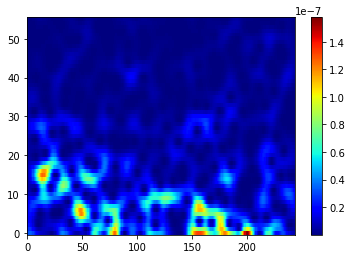

In [7]:
plt.imshow(S_auto[0,10,:,:].real, aspect = 'auto', cmap = 'jet', origin = 'lower'); plt.colorbar()

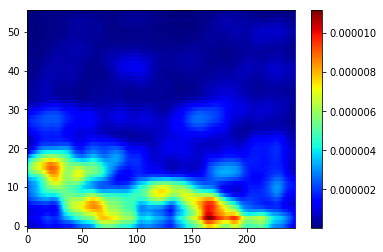

In [8]:
S_smooth = smooth_spectra(S_auto[0,10,:,:].T.real, 34, 5, fft=True)
plt.imshow(S_smooth.T, aspect = 'auto', cmap = 'jet', origin = 'lower'); plt.colorbar()

In [9]:
def pairwise_coherence(trial_number, index_pair, win_time, win_freq):
    channel1, channel2 = pairs[index_pair,0], pairs[index_pair,1]
    print(channel1)
    print(channel2)
    Sxy = W_ml[trial_number, channel1, :, :] * np.conj(W_ml[trial_number, channel2, :, :])
    Sxx = smooth_spectra(S_auto[trial_number,channel1, :, :].T, win_time, win_freq, fft=True).T
    Syy = smooth_spectra(S_auto[trial_number,channel2, :, :].T, win_time, win_freq, fft=True).T
    Sxy = smooth_spectra(Sxy.T, win_time, win_freq, fft=True).T
    return Sxy * np.conj(Sxy) / (Sxx * Syy )

In [10]:
start = time.time()
coh = pairwise_coherence(0, 454, 34, 5)
end = time.time()

print('Elapsed time to load super-tensor: ' +str((end - start)/60) + ' min.' )

10
30
Elapsed time to load super-tensor: 0.00015065272649129232 min.


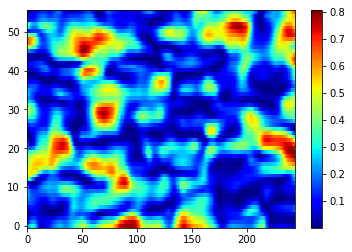

In [11]:
plt.imshow(coh.real, aspect = 'auto', cmap = 'jet', origin = 'lower'); plt.colorbar()

In [24]:
start = time.time()

coh = Parallel(n_jobs=-1,  prefer="threads", backend='loky', timeout=1e6)(
        delayed(pairwise_coherence)(0, index_pair, 34, 5)
                for index_pair in range(pairs.shape[0]) )

end = time.time()

print('Elapsed time to load super-tensor: ' +str((end - start)/1) + ' sec.' )

Elapsed time to load super-tensor: 13.95817255973816 sec.


In [25]:
np.array(coh).shape

(1176, 56, 244)

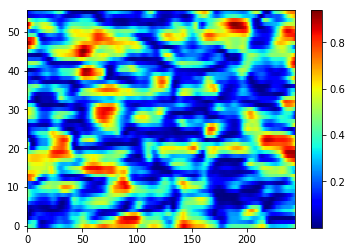

In [23]:
plt.imshow(np.array(coh)[454,:,:].real, aspect = 'auto', cmap = 'jet', origin = 'lower'); plt.colorbar()

In [15]:
session_data.keys()

dict_keys(['data', 'info', 'path'])

In [16]:
index_pair = 454
pairs[index_pair,0], pairs[index_pair,1]

(10, 30)

In [17]:
pairs

array([[ 0,  1],
       [ 0,  2],
       [ 0,  3],
       ...,
       [46, 47],
       [46, 48],
       [47, 48]])

In [18]:
W_ml.shape

(540, 49, 56, 244)

In [19]:
Sxy = W_ml[:,pairs[:,0], :,:] * np.conj(W_ml[0,pairs[:,0], :,:])

MemoryError: 

In [ ]:
np.real(W_ml)[:,pairs[:,0], :,:]

In [ ]:
pairs[:,0]

In [ ]:
np.zeros([540,1176,56,244])